In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func , inspect
from sqlalchemy import distinct

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)

In [11]:
inspector.get_table_names()
columns1 = inspector.get_columns('measurement')
columns2 = inspector.get_columns('station')
for column in columns1:
    print(column["name"], column["type"])
print("")
for column in columns2:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

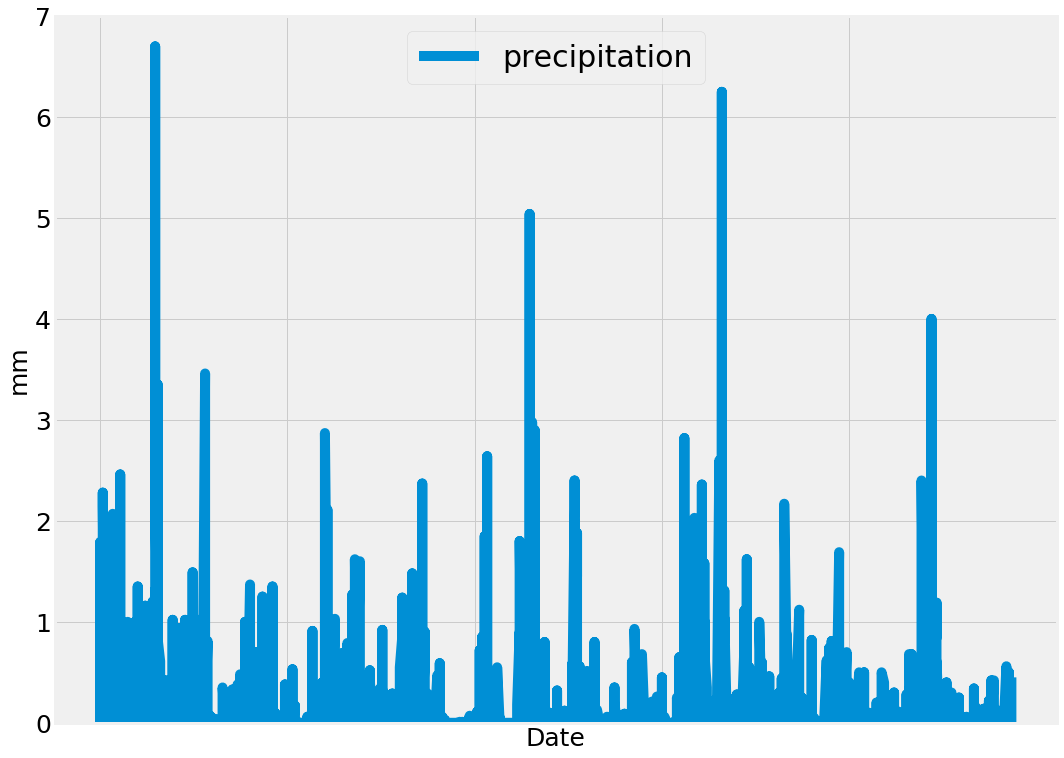

In [12]:

# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(measurement.date).order_by(measurement.date.desc()).first()

year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
year_ago = str(year_ago)
# Perform a query to retrieve the data and precipitation scores
rain_day = session.query(measurement.date,measurement.prcp)\
.filter(measurement.date <= '2017-08-23')\
.filter(measurement.date >= year_ago).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
rain_db = pd.DataFrame(rain_day).sort_values('date')
# Sort the dataframe by date
rain_db = rain_db.set_index('date').dropna()
rain_db = rain_db.rename(columns ={'prcp':'precipitation'})
# Use Pandas Plotting with Matplotlib to plot the data
f, ax = plt.subplots(figsize = (16,13))

ax.plot(rain_db.index,rain_db.precipitation, linewidth= 10)

ax.legend(loc = "upper center",prop={'size': 30})

ax.set_xlabel('Date', fontsize= '25')
ax.set_ylabel('mm', fontsize= '25')

ax.set_xticks(range(0,375,75))

ax.set_ylim([0,7])
ax.axes.tick_params(axis = 'x',bottom=False,labelbottom = False)
ax.axes.tick_params( axis = 'y',labelsize = '25')
plt.show()


![precipitation](Images/precipitation.png)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_dict = {
    'count':rain_db.precipitation.count(),
    'mean':rain_db.precipitation.mean(),
    'std':rain_db.precipitation.std(),
    'min':rain_db.precipitation.min(),
    '25%':rain_db.precipitation.quantile(.25),
    '50%':rain_db.precipitation.quantile(.50),
    '75%':rain_db.precipitation.quantile(.75),
    'max':rain_db.precipitation.max()}
rain_summ = pd.DataFrame(rain_dict, index = range(len(rain_dict)))\
                .T\
                .rename(columns = {0:'precipitation'})\
                .precipitation
rain_summary = pd.DataFrame(rain_summ)
rain_summary

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [14]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(distinct(measurement.station))).all()

[(9)]

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(measurement.station,func.count(measurement.station))\
.group_by(measurement.station)\
.order_by(func.count(measurement.station).desc())\
.all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temps = [func.min(measurement.tobs),
        func.max(measurement.tobs),
        func.avg(measurement.tobs)]

session.query(*temps)\
.filter(measurement.station == 'USC00519281')\
.all()


[(54.0, 85.0, 71.66378066378067)]

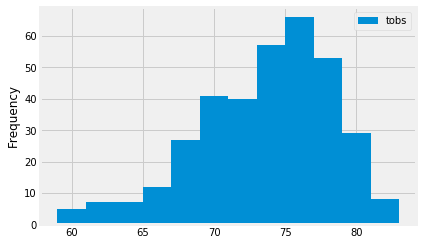

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_temps = session.query(measurement.tobs)\
            .filter(measurement.station == "USC00519281")\
            .filter(measurement.date <= '2017-08-23')\
            .filter(measurement.date >= year_ago)\
            .all()
year_temps_db = pd.DataFrame(year_temps)
q, hs = plt.subplots(figsize = (6,4))
hs.hist(year_temps_db.tobs, bins= 12)

hs.legend()
hs.set_ylabel('Frequency')

plt.show()

![precipitation](Images/station-histogram.png)

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
#     """TMIN, TAVG, and TMAX for a list of dates."""
    temps = [func.min(measurement.tobs),
            func.max(measurement.tobs),
            func.avg(measurement.tobs)]
#    """Args:
#         start_date (string): A date string in the format %Y-%m-%d
#         end_date (string): A date string in the format %Y-%m-%d
        
#     Returns:
#         TMIN, TAVE, and TMAX
#     """
    return session.query(*temps)\
                    .filter(measurement.date >= start_date)\
                    .filter(measurement.date <= end_date)\
                    .all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 74.0, 69.57142857142857)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start='2017-07-20'
end='2017-07-27'

vac_temps = calc_temps(start,end)
print(vac_temps)

[(72.0, 84.0, 78.38461538461539)]


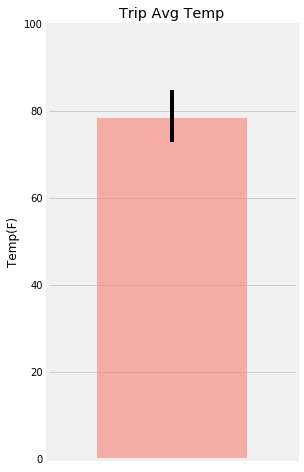

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
p, vc = plt.subplots(figsize=(4,8))

vc.bar(0,vac_temps[0][2],
        yerr = [[vac_temps[0][1]-vac_temps[0][2]],
                [vac_temps[0][2]-vac_temps[0][0]]],
                color = 'salmon',
                alpha = .6,
                width = .6)



vc.set_xlim(-.5,.5)
vc.set_ylim(0,100)

vc.set_title("Trip Avg Temp")
vc.set_ylabel("Temp(F)")

vc.axes.get_xaxis().set_visible(False)


plt.show()

In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

stations = [station.station,
           station.name,
           station.latitude,
           station.longitude,
           station.elevation]

# stations =  session.query(*stations).all()

prec_station = session.query(measurement.station,func.sum(measurement.tobs).label('total_rain'))\
                .filter(measurement.date >= start)\
                .filter(measurement.date <= end)\
                .group_by(measurement.station)\
                .order_by(func.sum(measurement.tobs).desc())\
                .subquery()
rf = session.query(*stations,prec_station.c.total_rain)\
    .join(prec_station, station.station ==prec_station.c.station)\
    .all()


print(rf)

[('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 641.0), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 620.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 638.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 399.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 561.0), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 616.0), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 601.0)]


## Optional Challenge Assignment

In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    sel = [func.min(measurement.tobs),
           func.avg(measurement.tobs),
           func.max(measurement.tobs)]
    
    return session.query(*sel)\
                    .filter(func.strftime("%m-%d", measurement.date) == date)\
                    .all()[0]
    
daily_normals("01-01")

(62.0, 69.15384615384616, 77.0)

In [37]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
# Set the start and end date of the trip
start = dt.date(2017,7,20)
end = dt.date(2017,7,27).strftime("%m-%d")
# Use the start and end date to create a range of dates
date_range = []
count = 0

while end not in date_range:
    next_day = (start + dt.timedelta(days=count)).strftime("%m-%d")
    date_range.append(next_day)
    count += 1
    
for day in date_range:
    normals.append(daily_normals(day))
    
date_range = ['2018-' + date for date in date_range]
# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
normals

[(69.0, 75.46296296296296, 82.0),
 (69.0, 76.9245283018868, 83.0),
 (69.0, 75.78846153846153, 81.0),
 (70.0, 76.20370370370371, 84.0),
 (69.0, 76.55555555555556, 81.0),
 (67.0, 76.89090909090909, 84.0),
 (71.0, 76.4423076923077, 86.0),
 (68.0, 76.58181818181818, 83.0)]

In [38]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns = ['Tmin','Tavg','Tmax'], index = date_range)
normals_df.index.name = 'date'
normals_df

,Tmin,Tavg,Tmax
date,,,
2018-07-20,69.0,75.462963,82.0
2018-07-21,69.0,76.924528,83.0
2018-07-22,69.0,75.788462,81.0
2018-07-23,70.0,76.203704,84.0
2018-07-24,69.0,76.555556,81.0
2018-07-25,67.0,76.890909,84.0
2018-07-26,71.0,76.442308,86.0
2018-07-27,68.0,76.581818,83.0


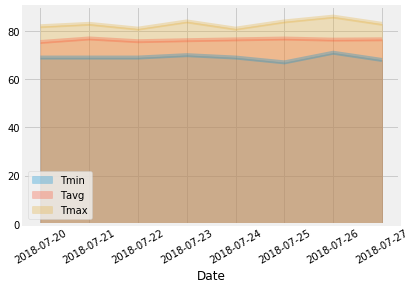

In [44]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked = False, alpha = .3, xticks = range(8),)
plt.xlabel('Date')
plt.xticks(rotation = 30)
plt.show()
